## Challenge B (Total: 5 Points):
#### Scenario: 
Swiss Marketplace Group (SMG) wants to analyse its general listings (classifieds) data to
determine which product types are the most popular and which ones are idle. The company wants to
use this information to make decisions about which product types they should invest in different ways
of promoting (idle listings).


#### Task 1 (2.5 Points): 
Write a script/query that shows the following information:
- a) The top 3 selling product types by platform.
- b) The bottom 3 selling product types by platform.
- c) The top 3 idle product types (amount of days).
- d) The total amount sold by product type (monetary value rounded to two decimals).
- e) Any other insights you could learn from the data that would be useful for the company to know.

#### Task 2 (2.5 Points): 
Create data visualizations (charts or/and dashboards) that can be used to explain
the results of task 1 (a,b,c,d,e).
- a) The top 3 selling product types by platform.
- b) The bottom 3 selling product types by platform.
- c) The top 3 idle product types (amount of days).
- d) The total amount sold by product type (monetary value rounded to two decimals).
- e) Any other insights you could learn from the data that would be useful for the company to know.


### General Approach
- Analysis below combines both tasks for each analysis (script & visualisations)
- Considered using Looker Studio, after first plotting with Python
    - I deemded the Python visualisations, whilst simple, sufficient for the task at hand
    - Given the time constraints, I decided against the use of Looker Studio
    - In a production dwh environment, a BI tool would naturally be the better solution
- Improvments for the Python visualisations would include increase text size of graph titles, x/y-labels, coloring of individual bars, but again was rejected given time constratins
 

### SQL
- Decided SQL queries over DataFrame manipulations with Pandas, as more appropriate for the task
    - No advanced analytics where Python has obvious advantages
    - BI nature of the task
    - Data manipulation / joins / window functions can be easily implemented in SQL and is visually easier to follow
    
- For all the task, the same base CTE which contains necessary joins
- When required, there are additional CTEs to create the desired dataset (e.g. Window functions to Rank top/bottom items)


#### SQL: Calculating 'Idle Products' / days_listed
- I consider idle products which have yet to be sold, and therefore don't yet have a 'listing_end_date'
- Given the static nature of dataset, I didn't want to use the current date, but instead chose the maximum date within the dataset as the end_date on which to calculate the days_listed

In [52]:
import os
import pandas as pd
import pandas_gbq as pd_gbq
from google.cloud import bigquery
from matplotlib import pyplot as plt

In [4]:
### Create client using json file & project_id
client = bigquery.Client.from_service_account_json(json_credentials_path="credentials.json")
pysqldf = lambda q: sqldf(q, globals())

## a) Top 3 selling product types by platform

In [48]:
sql_top_3 = """
    with product_listings as (
      select
          cl.*
        , dpt.product_type
        , replace(dp.platform,'.ch','') as platform
        , date_diff(coalesce(last_update_date, DATE(2022,01,28)),  creation_date, day) as days_listed
      from `cln_listings.cln_listings`cl
      left join `dim_platform.dim_platform` dp on cl.platform_id = dp.platform_id and cl.creation_date between dp.valid_from and dp.valid_to
      left join `dim_product_type.dim_product_type` dpt on cl.product_type_id = dpt.product_type_id  and dpt.product_type != 'Sofaa'
    ),
    product_listings_agg as (
      select
          platform
        , product_type
        , count(distinct listing_id) as listings
        , round(sum(price),2) as total_ammount
        , round(avg(days_listed),2) as avg_days_listed
      from product_listings
      group by 1,2
    ),
    product_listings_agg_ranked as (
      select
          platform
        , product_type
        , listings
        , total_ammount
        , avg_days_listed
        , rank() over (partition by platform order by listings desc) listings_ranked_best
        , rank() over (partition by platform order by listings asc) listings_ranked_worst
      from product_listings_agg
    )
    select
    platform, product_type, listings
    from product_listings_agg_ranked 
    where listings_ranked_best in (1,2,3) 
    order by platform, listings_ranked_best asc
    """

dft3 = client.query(sql_top_3).to_dataframe()

In [51]:
dft3

,platform,product_type,listings
0,Anibis,Tennis racket,14
1,Anibis,Glass bottle,10
2,Anibis,Iron,6
3,Ricardo,Radio,10
4,Ricardo,Mountain Bike,9
5,Ricardo,Snowboard,5
6,Tutti,Notebook,6
7,Tutti,Skiis,2
8,Tutti,Watch,2
9,Tutti,Mousepad,2


<AxesSubplot:title={'center':'Tutti'}, xlabel='product_type'>

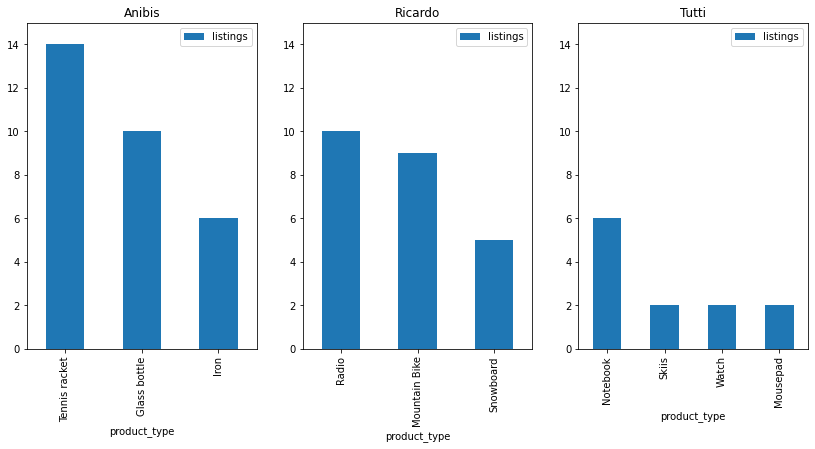

In [66]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

dft3[dft3['platform']=='Anibis'].plot(kind='bar', x='product_type', y='listings', ax=ax1, figsize=(14,6), ylim=(0,15), title='Anibis')
dft3[dft3['platform']=='Ricardo'].plot(kind='bar', x='product_type', y='listings', ax=ax2, figsize=(14,6), ylim=(0,15), title='Ricardo')
dft3[dft3['platform']=='Tutti'].plot(kind='bar', x='product_type', y='listings', ax=ax3, figsize=(14,6), ylim=(0,15), title='Tutti')



## b) Bottom 3 selling product types by platform

In [72]:
sql_bottom_3 = """
    with product_listings as (
      select
          cl.*
        , dpt.product_type
        , replace(dp.platform,'.ch','') as platform
        , date_diff(coalesce(last_update_date, DATE(2022,01,28)),  creation_date, day) as days_listed
      from `cln_listings.cln_listings`cl
      left join `dim_platform.dim_platform` dp on cl.platform_id = dp.platform_id and cl.creation_date between dp.valid_from and dp.valid_to
      left join `dim_product_type.dim_product_type` dpt on cl.product_type_id = dpt.product_type_id  and dpt.product_type != 'Sofaa'
    ),
    product_listings_agg as (
      select
          platform
        , product_type
        , count(distinct listing_id) as listings
        , round(sum(price),2) as total_ammount
        , round(avg(days_listed),2) as avg_days_listed
      from product_listings
      group by 1,2
    ),
    product_listings_agg_ranked as (
      select
          platform
        , product_type
        , listings
        , total_ammount
        , avg_days_listed
        , rank() over (partition by platform order by listings desc) listings_ranked_best
        , rank() over (partition by platform order by listings asc) listings_ranked_worst
        , rank() over (partition by platform order by total_ammount asc) total_amount_ranked_worst
      from product_listings_agg
    )
    select
    platform, product_type, listings, total_ammount
    from product_listings_agg_ranked
    where listings_ranked_worst in (1,2,3) and total_amount_ranked_worst in (1,2,3)
    order by platform, listings_ranked_worst asc
    """

dfb3 = client.query(sql_bottom_3).to_dataframe()

#### Note
- Given the small dataset size, it wasn't possible to isolate the 3 worst products, since many more shared the 1 listing
- Dataset has therefore been further filtered, to fetch the 3 worst performing by both listing & total_amount (price)

In [73]:
dfb3

,platform,product_type,listings,total_ammount
0,Anibis,Winter hiking boots,1,9.0
1,Anibis,Mirror,1,36.0
2,Anibis,Carpet,1,58.0
3,Ricardo,Mattress,1,22.0
4,Ricardo,Table,1,22.0
5,Ricardo,Winter hiking boots,1,58.0
6,Tutti,Tennis racket,1,1.0
7,Tutti,Climbing shoes,1,6.0
8,Tutti,Lamp,1,12.0


<AxesSubplot:title={'center':'Tutti'}, xlabel='product_type'>

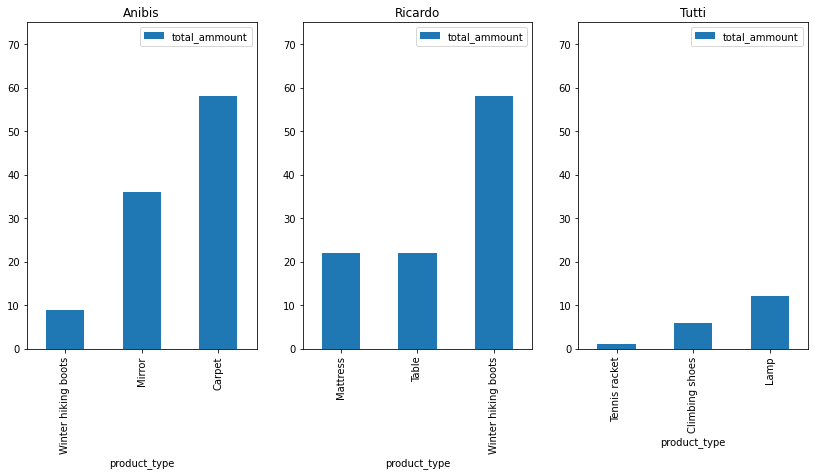

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

dfb3[dfb3['platform']=='Anibis'].plot(kind='bar', x='product_type', y='total_ammount', ax=ax1, figsize=(14,6), ylim=(0,75), title='Anibis')
dfb3[dfb3['platform']=='Ricardo'].plot(kind='bar', x='product_type', y='total_ammount', ax=ax2, figsize=(14,6), ylim=(0,75), title='Ricardo')
dfb3[dfb3['platform']=='Tutti'].plot(kind='bar', x='product_type', y='total_ammount', ax=ax3, figsize=(14,6), ylim=(0,75), title='Tutti')

## c) Top 3 idle product types

In [27]:
sql_top_3_idle = """
    with product_listings as (
      select
          cl.*
        , dpt.product_type
        , replace(dp.platform,'.ch','') as platform
        , date_diff(coalesce(last_update_date, DATE(2022,01,28)),  creation_date, day) as days_listed
      from `cln_listings.cln_listings`cl
      left join `dim_platform.dim_platform` dp on cl.platform_id = dp.platform_id and cl.creation_date between dp.valid_from and dp.valid_to
      left join `dim_product_type.dim_product_type` dpt on cl.product_type_id = dpt.product_type_id  and dpt.product_type != 'Sofaa'
    ),
    product_listings_agg as (
      select
          product_type
        , count(distinct listing_id) as listings
        , round(sum(price),2) as total_ammount
        , round(avg(days_listed),2) as avg_days_listed
      from product_listings
      group by 1
    )
    select
          product_type
        , avg_days_listed
        , listings
    from product_listings_agg 
    order by 2 desc
    limit 3
"""

dft3i = client.query(sql_top_3_idle).to_dataframe()

In [28]:
dft3i               

,product_type,avg_days_listed,listings
0,Guitar,46.0,1
1,Baseball,44.0,2
2,Winter hiking boots,43.0,2


<AxesSubplot:xlabel='product_type'>

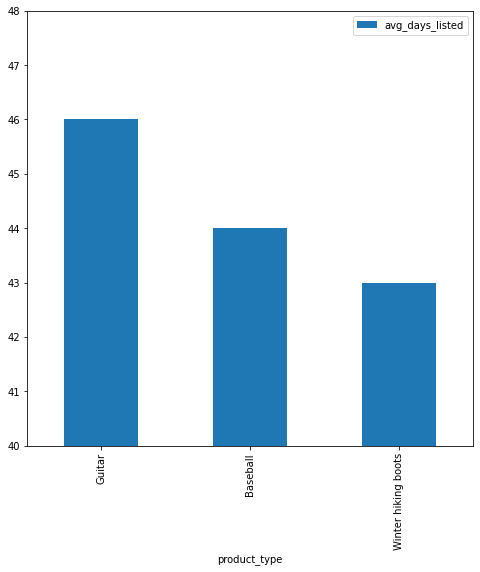

In [45]:
dft3i.plot(kind='bar', x='product_type',  y='avg_days_listed', figsize=(8,8), ylim=(40,48))

## d) The total amount sold by product type (monetary value rounded to two decimals)

In [33]:
sql_top_3_value = """
    with product_listings as (
      select
          cl.*
        , dpt.product_type
        , replace(dp.platform,'.ch','') as platform
        , date_diff(coalesce(last_update_date, DATE(2022,01,28)),  creation_date, day) as days_listed
      from `cln_listings.cln_listings`cl
      left join `dim_platform.dim_platform` dp on cl.platform_id = dp.platform_id and cl.creation_date between dp.valid_from and dp.valid_to
      left join `dim_product_type.dim_product_type` dpt on cl.product_type_id = dpt.product_type_id and dpt.product_type != 'Sofaa'
    ),
    product_listings_agg as (
      select
          product_type
        , count(distinct listing_id) as listings
        , round(sum(price),2) as total_ammount
        , round(avg(days_listed),2) as avg_days_listed
      from product_listings
      group by 1
    )
    select
          product_type
        , total_ammount
        , listings
    from product_listings_agg 
    order by 2 desc
    limit 3
"""

dft3v = client.query(sql_top_3_value).to_dataframe()

In [34]:
dft3v

,product_type,total_ammount,listings
0,Glass bottle,5032.00,11
1,Iron,3946.00,6
2,Monitor,3372.87,2


<AxesSubplot:xlabel='product_type'>

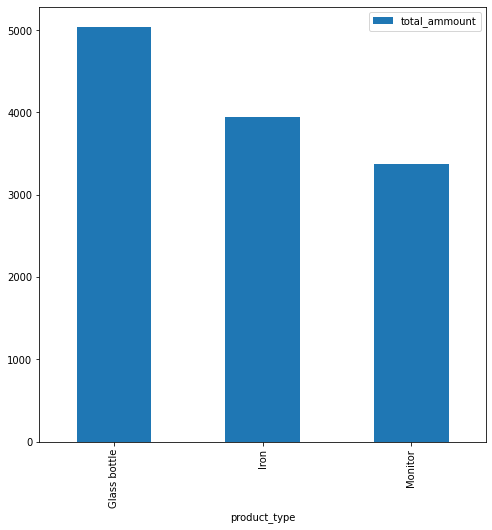

In [44]:
dft3v.plot(kind='bar', x='product_type',  y='total_ammount', figsize=(8,8))

## e) Any other insights you could learn from the data that would be useful for the company to know?

- Given time constraints, I will consider tackling this analysis once the rest of the Case Study is complete


## Analysis Insights for consideration:

- Analyse total revenue, whilst considering the number of listings and average_price
    - Consider promoting products with high number of number of listings, which suggests high product supply & demand
    
    
- Analyse total revenue & listings whilst considering the average listing times 


- Analyse products across additional product and geo/user dimensions
    - Difficult given the low volume of listings in datset, plus the missing dimensions in the product_type table